# A/B Test Analysis: Mobile Checkout Theme

## 1. Introduction
This notebook analyzes the results of an A/B test experiment aimed at improving the design of a product payment page. The goal is to determine if a new mobile checkout theme (`mobile_checkout_theme_new`) performs better than the old theme (`mobile_checkout_theme_old`) in terms of user engagement and conversion.

## 2. Import Libraries
First, we import the necessary libraries for data analysis, statistical testing, and visualization.

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Load Data
We load the raw experiment data from the `experiment_raw.csv` file.

In [2]:
df = pd.read_csv("experiment_raw.csv")
df.head()

,id,date,country,os,experiment_mobile_checkout_theme,transaction_try,transaction_success
0,10500155,2020-05-21,USA,android,mobile_checkout_theme_old,0,0
1,10500150,2020-05-21,USA,ios,mobile_checkout_theme_new,0,0
2,10500139,2020-05-21,USA,android,mobile_checkout_theme_new,0,0
3,10500135,2020-05-21,USA,ios,mobile_checkout_theme_new,0,0
4,10500134,2020-05-21,USA,android,mobile_checkout_theme_new,0,0


## 4. Overall Analysis
We perform a Chi-Squared test to determine if there is a statistically significant difference between the two themes in terms of purchase attempts and successful purchases.

In [3]:
contingency_table_attempt = pd.crosstab(df['experiment_mobile_checkout_theme'], df['transaction_try'])
chi2_attempt, p_value_attempt, _, _ = chi2_contingency(contingency_table_attempt)

contingency_table_success = pd.crosstab(df['experiment_mobile_checkout_theme'], df['transaction_success'])
chi2_success, p_value_success, _, _ = chi2_contingency(contingency_table_success)

print(f"Overall Purchase Attempt: chi2={chi2_attempt}, p-value={p_value_attempt}")
print(f"Overall Purchase Success: chi2={chi2_success}, p-value={p_value_success}")

Overall Purchase Attempt: chi2=50.336530218514525, p-value=1.295160310569741e-12
Overall Purchase Success: chi2=9.255977445264337, p-value=0.002347280214710115


## 5. Analysis by Operating System
We repeat the analysis for each major operating system (Android and iOS) to check for any platform-specific differences.

In [4]:
for os in df['os'].unique():
    df_os = df[df['os'] == os]
    
    contingency_table_attempt_os = pd.crosstab(df_os['experiment_mobile_checkout_theme'], df_os['transaction_try'])
    if contingency_table_attempt_os.shape[0] > 1:
        chi2_attempt_os, p_value_attempt_os, _, _ = chi2_contingency(contingency_table_attempt_os)
    else:
        chi2_attempt_os, p_value_attempt_os = None, None

    contingency_table_success_os = pd.crosstab(df_os['experiment_mobile_checkout_theme'], df_os['transaction_success'])
    if contingency_table_success_os.shape[0] > 1:
        chi2_success_os, p_value_success_os, _, _ = chi2_contingency(contingency_table_success_os)
    else:
        chi2_success_os, p_value_success_os = None, None

    print(f"OS: {os}")
    print(f"  Purchase Attempt: chi2={chi2_attempt_os}, p-value={p_value_attempt_os}")
    print(f"  Purchase Success: chi2={chi2_success_os}, p-value={p_value_success_os}")

OS: android
  Purchase Attempt: chi2=24.083961681023624, p-value=9.222523571316933e-07
  Purchase Success: chi2=4.44315106103209, p-value=0.03504151496321571
OS: ios
  Purchase Attempt: chi2=26.340292597964094, p-value=2.8625402742167604e-07
  Purchase Success: chi2=5.078377934868641, p-value=0.024226024201840408
OS: nan
  Purchase Attempt: chi2=None, p-value=None
  Purchase Success: chi2=None, p-value=None


## 6. Time-Series Analysis
We analyze the stability of the conversion rates over time by plotting the daily success rates for both themes.

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date_only'] = df['date'].dt.date

daily_analysis = df.groupby(['date_only', 'experiment_mobile_checkout_theme']).agg(
    total_users=('id', 'nunique'),
    purchase_attempts=('transaction_try', 'sum'),
    successful_purchases=('transaction_success', 'sum')
).reset_index()

daily_analysis['attempt_rate'] = daily_analysis['purchase_attempts'] / daily_analysis['total_users']
daily_analysis['success_rate'] = daily_analysis['successful_purchases'] / daily_analysis['total_users']

daily_analysis.head()

,date_only,experiment_mobile_checkout_theme,total_users,purchase_attempts,successful_purchases,attempt_rate,success_rate
0,2020-04-28,mobile_checkout_theme_new,50,11,4,0.220000,0.080000
1,2020-04-28,mobile_checkout_theme_old,40,8,3,0.200000,0.075000
2,2020-04-29,mobile_checkout_theme_new,203,52,22,0.256158,0.108374
3,2020-04-29,mobile_checkout_theme_old,171,30,15,0.175439,0.087719
4,2020-04-30,mobile_checkout_theme_new,572,184,62,0.321678,0.108392


## 7. Data Visualization
Finally, we create a professional and insightful visualization of the daily purchase success rates.

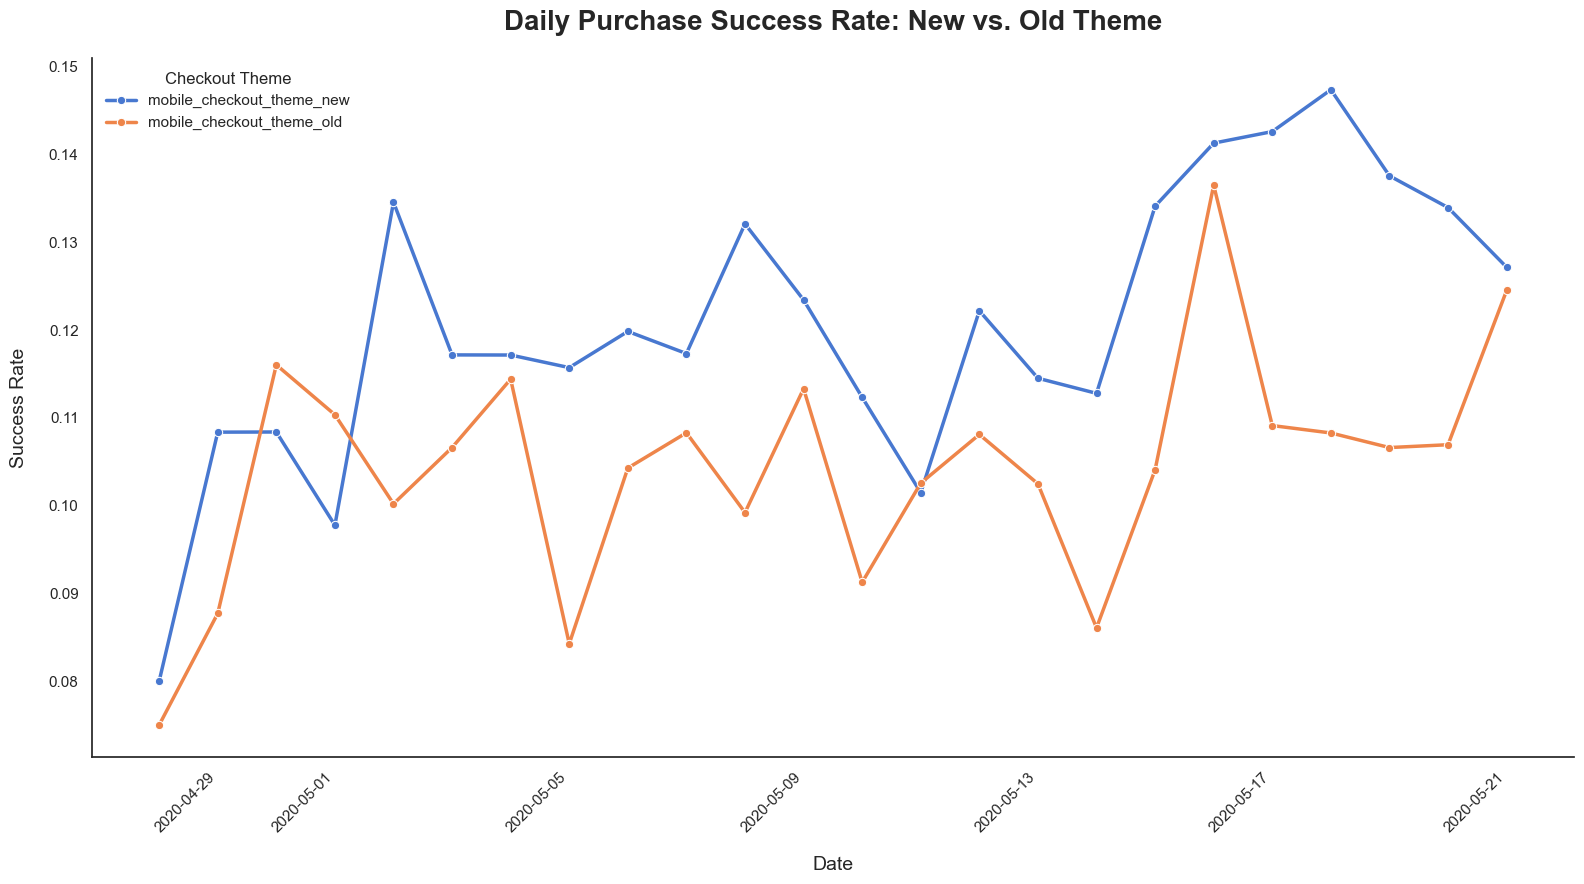

In [6]:
sns.set_theme(style="white", palette="muted")

plt.figure(figsize=(16, 9))
ax = sns.lineplot(
    data=daily_analysis, 
    x='date_only', 
    y='success_rate', 
    hue='experiment_mobile_checkout_theme', 
    marker='o', 
    linestyle='-',
    linewidth=2.5
)

plt.title('Daily Purchase Success Rate: New vs. Old Theme', fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=15)
plt.ylabel('Success Rate', fontsize=14, labelpad=15)
plt.xticks(rotation=45, ha="right")
plt.legend(title='Checkout Theme', frameon=False, loc='upper left')

ax.grid(False)
sns.despine()

plt.tight_layout()

plt.savefig("conversion_rates.png")
plt.show()